Using device: cuda



100%|██████████| 169M/169M [00:03<00:00, 42.5MB/s]


显示训练图片示例...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


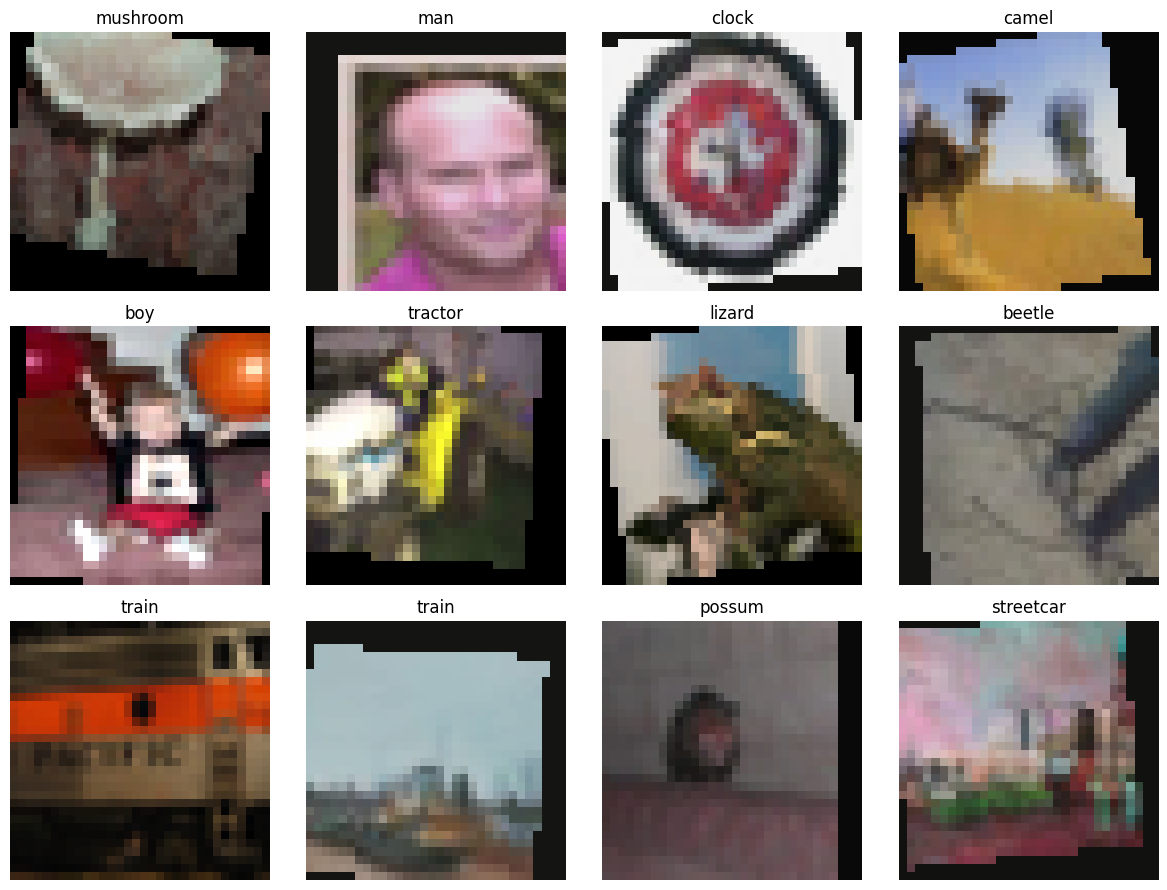

加载带CBAM注意力机制的预训练ResNet18模型...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


模型参数量: 11,526,700
可训练参数量: 11,526,700
开始训练...
Epoch: 1 | Batch: 0/430 | Loss: 4.5961 | Top1: 0.78% | Top5: 4.69%
Epoch: 1 | Batch: 100/430 | Loss: 4.6036 | Top1: 1.31% | Top5: 5.93%
Epoch: 1 | Batch: 200/430 | Loss: 4.5789 | Top1: 1.64% | Top5: 7.40%
Epoch: 1 | Batch: 300/430 | Loss: 4.4569 | Top1: 3.28% | Top5: 11.96%
Epoch: 1 | Batch: 400/430 | Loss: 4.2754 | Top1: 5.40% | Top5: 17.68%
Test Results: Loss: 3.0458 | Top1: 22.74% | Top5: 53.91%
保存最佳模型，准确率: 22.74%
Epoch 1/100 | Train Acc: 6.15% | Test Acc: 22.74% | Best Acc: 22.74%
--------------------------------------------------------------------------------
Epoch: 2 | Batch: 0/430 | Loss: 3.3018 | Top1: 15.62% | Top5: 46.09%
Epoch: 2 | Batch: 100/430 | Loss: 3.1972 | Top1: 19.65% | Top5: 49.71%
Epoch: 2 | Batch: 200/430 | Loss: 3.0715 | Top1: 22.14% | Top5: 53.11%
Epoch: 2 | Batch: 300/430 | Loss: 2.9632 | Top1: 24.49% | Top5: 55.90%
Epoch: 2 | Batch: 400/430 | Loss: 2.8711 | Top1: 26.42% | Top5: 58.28%
Test Results: Loss: 1.9562 | To

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torch.optim.lr_scheduler import CosineAnnealingLR

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


# ==================== 注意力机制模块 ====================

class CBAM(nn.Module):
    """Convolutional Block Attention Module"""

    def __init__(self, channels, reduction=16):
        super(CBAM, self).__init__()

        # 通道注意力
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
            nn.Sigmoid()
        )

        # 空间注意力
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 通道注意力
        channel_weights = self.channel_attention(x)
        x = x * channel_weights

        # 空间注意力
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_input = torch.cat([avg_out, max_out], dim=1)
        spatial_weights = self.spatial_attention(spatial_input)
        x = x * spatial_weights

        return x


class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block"""

    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class SimpleAttention(nn.Module):
    """简单的空间注意力机制"""

    def __init__(self, in_channels):
        super(SimpleAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 16, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 16, 1, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights


# ==================== 使用预训练的ResNet18模型 + 注意力机制 ====================

class PretrainedResNet18WithAttention(nn.Module):
    def __init__(self, num_classes=100, attention_type='cbam'):
        super(PretrainedResNet18WithAttention, self).__init__()
        self.attention_type = attention_type

        # 加载预训练的ResNet18模型
        self.backbone = torchvision.models.resnet18(pretrained=True)

        # 替换最后的全连接层以适应CIFAR-100的100个类别
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

        # 由于CIFAR-100是32x32图像，而预训练模型通常用于224x224
        # 我们需要调整第一个卷积层
        self.backbone.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # 移除第一个池化层以适应小尺寸图像
        self.backbone.maxpool = nn.Identity()

        # 添加注意力机制到不同的层
        self._add_attention_mechanisms()

    def _add_attention_mechanisms(self):
        """在ResNet的不同阶段添加注意力机制"""
        if self.attention_type == 'cbam':
            # 在layer1, layer2, layer3, layer4之后添加CBAM注意力
            self.backbone.layer1 = nn.Sequential(
                self.backbone.layer1,
                CBAM(64)
            )
            self.backbone.layer2 = nn.Sequential(
                self.backbone.layer2,
                CBAM(128)
            )
            self.backbone.layer3 = nn.Sequential(
                self.backbone.layer3,
                CBAM(256)
            )
            self.backbone.layer4 = nn.Sequential(
                self.backbone.layer4,
                CBAM(512)
            )
        elif self.attention_type == 'se':
            # 添加SE注意力机制
            self.backbone.layer1 = nn.Sequential(
                self.backbone.layer1,
                SEBlock(64)
            )
            self.backbone.layer2 = nn.Sequential(
                self.backbone.layer2,
                SEBlock(128)
            )
            self.backbone.layer3 = nn.Sequential(
                self.backbone.layer3,
                SEBlock(256)
            )
            self.backbone.layer4 = nn.Sequential(
                self.backbone.layer4,
                SEBlock(512)
            )
        elif self.attention_type == 'simple':
            # 添加简单注意力机制
            self.backbone.layer1 = nn.Sequential(
                self.backbone.layer1,
                SimpleAttention(64)
            )
            self.backbone.layer2 = nn.Sequential(
                self.backbone.layer2,
                SimpleAttention(128)
            )
            self.backbone.layer3 = nn.Sequential(
                self.backbone.layer3,
                SimpleAttention(256)
            )
            self.backbone.layer4 = nn.Sequential(
                self.backbone.layer4,
                SimpleAttention(512)
            )

    def forward(self, x):
        return self.backbone(x)


# ==================== 数据预处理和加载 ====================

def get_data_loaders(batch_size=128, use_half_test_for_train=True):
    """
    获取数据加载器
    Args:
        batch_size: 批次大小
        use_half_test_for_train: 是否将一半测试集数据用于训练
    """
    # 数据增强和预处理 - 使用更适合预训练模型的预处理
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])

    # 加载CIFAR-100数据集
    train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                                  download=True, transform=transform_train)
    test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                                 download=True, transform=transform_test)

    if use_half_test_for_train:
        test_size = len(test_dataset)
        half_test_size = test_size // 2
        indices = torch.randperm(test_size).tolist()
        test_to_train_indices = indices[:half_test_size]
        original_test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                                              download=True, transform=transform_test)

        combined_train_dataset = ConcatDataset([
            train_dataset,
            Subset(original_test_dataset, test_to_train_indices)
        ])
        train_loader = DataLoader(combined_train_dataset, batch_size=batch_size,
                                  shuffle=True, num_workers=4)
        test_loader = DataLoader(test_dataset, batch_size=batch_size,
                                 shuffle=False, num_workers=4)
    else:
        # 使用原始的数据划分
        train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                  shuffle=True, num_workers=4)
        test_loader = DataLoader(test_dataset, batch_size=batch_size,
                                 shuffle=False, num_workers=4)

    return train_loader, test_loader


# ==================== 工具函数 ====================

class AverageMeter:
    """计算并存储平均值和当前值"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """计算指定k值的准确率"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def show_images(images, labels, class_names, num_images=12):
    """显示图片"""
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.ravel()

    for i in range(num_images):
        # 反标准化
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.5071, 0.4867, 0.4408])
        std = np.array([0.2675, 0.2565, 0.2761])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f'{class_names[labels[i]]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


# ==================== 训练和测试函数 ====================

def train(model, train_loader, criterion, optimizer, epoch, scheduler=None):
    """训练函数"""
    model.train()
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    end = time.time()

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 计算准确率
        prec1, prec5 = accuracy(outputs, targets, topk=(1, 5))
        losses.update(loss.item(), inputs.size(0))
        top1.update(prec1.item(), inputs.size(0))
        top5.update(prec5.item(), inputs.size(0))

        # 计时
        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} | Batch: {batch_idx}/{len(train_loader)} | '
                  f'Loss: {losses.avg:.4f} | Top1: {top1.avg:.2f}% | Top5: {top5.avg:.2f}%')

    if scheduler:
        scheduler.step()

    return top1.avg, losses.avg


def test(model, test_loader, criterion):
    """测试函数"""
    model.eval()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            prec1, prec5 = accuracy(outputs, targets, topk=(1, 5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))

    print(f'Test Results: Loss: {losses.avg:.4f} | Top1: {top1.avg:.2f}% | Top5: {top5.avg:.2f}%')
    return top1.avg, top5.avg, losses.avg


# ==================== 主函数 ====================

def main(attention_type='cbam', use_half_test_for_train=True):
    # 超参数设置
    batch_size = 128
    epochs = 100
    learning_rate = 0.01
    weight_decay = 1e-4
    momentum = 0.9

    # 获取数据加载器（使用增强的训练集）
    train_loader, test_loader = get_data_loaders(batch_size, use_half_test_for_train)

    # 获取类别名称
    if use_half_test_for_train:
        class_names = train_loader.dataset.datasets[0].classes
    else:
        class_names = train_loader.dataset.classes

    # 显示一些训练图片
    print("显示训练图片示例...")
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    show_images(images, labels, class_names)

    # 初始化带注意力机制的预训练模型
    print(f"加载带{attention_type.upper()}注意力机制的预训练ResNet18模型...")
    model = PretrainedResNet18WithAttention(num_classes=100, attention_type=attention_type).to(device)

    # 打印模型结构
    print(f"模型参数量: {sum(p.numel() for p in model.parameters()):,}")
    print(f"可训练参数量: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # 损失函数和优化器
    criterion = nn.CrossEntropyLoss()

    # 对不同的参数组使用不同的学习率
    backbone_params = []
    classifier_params = []
    attention_params = []

    for name, param in model.named_parameters():
        if 'backbone.fc' in name or 'backbone.layer4' in name:
            classifier_params.append(param)
        elif 'attention' in name.lower():
            attention_params.append(param)
        else:
            backbone_params.append(param)

    optimizer = optim.SGD([
        {'params': backbone_params, 'lr': learning_rate * 0.1},  # 基础层更小的学习率
        {'params': classifier_params, 'lr': learning_rate},  # 分类层正常学习率
        {'params': attention_params, 'lr': learning_rate}  # 注意力层正常学习率
    ], momentum=momentum, weight_decay=weight_decay)

    # 学习率调度器
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    # 训练历史记录
    train_acc_history = []
    test_acc_history = []
    train_loss_history = []
    test_loss_history = []

    best_acc = 0

    print("开始训练...")
    for epoch in range(1, epochs + 1):
        # 训练
        train_acc, train_loss = train(model, train_loader, criterion, optimizer, epoch, scheduler)

        # 测试
        test_acc, test_top5, test_loss = test(model, test_loader, criterion)

        # 记录历史
        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)

        # 保存最佳模型
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
                'attention_type': attention_type,
                'use_half_test_for_train': use_half_test_for_train
            }, f'best_pretrained_resnet18_{attention_type}_cifar100_augmented.pth')
            print(f'保存最佳模型，准确率: {best_acc:.2f}%')

        print(
            f'Epoch {epoch}/{epochs} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Best Acc: {best_acc:.2f}%')
        print('-' * 80)

    # 绘制训练曲线
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(test_acc_history, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Training and Test Accuracy (ResNet18 + {attention_type.upper()} + Augmented)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(test_loss_history, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Test Loss (ResNet18 + {attention_type.upper()} + Augmented)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'training_curves_{attention_type}_augmented.png')
    plt.show()

    print(f'训练完成！最佳测试准确率: {best_acc:.2f}%')


# ==================== 模型加载和测试 ====================

def load_and_test_model(attention_type='cbam', use_half_test_for_train=True):
    """加载最佳模型并进行测试"""
    print(f"加载带{attention_type.upper()}注意力机制的最佳模型进行测试...")

    # 初始化模型
    model = PretrainedResNet18WithAttention(num_classes=100, attention_type=attention_type).to(device)

    # 加载保存的模型
    checkpoint = torch.load(f'best_pretrained_resnet18_{attention_type}_cifar100_augmented.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    # 获取测试数据加载器（使用原始测试集）
    _, test_loader = get_data_loaders(batch_size=128, use_half_test_for_train=True)

    # 详细测试模型
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(100))
    class_total = list(0. for i in range(100))

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # 计算每个类别的准确率
            c = (predicted == targets).squeeze()
            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    accuracy = 100. * correct / total
    print(f'最终测试准确率: {accuracy:.2f}%')

    # 打印每个类别的准确率
    print("\n部分类别准确率:")
    for i in range(10):  # 只显示前10个类别
        if class_total[i] > 0:
            print(f'{test_loader.dataset.classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

    # 显示一些测试图片和预测结果
    print("\n显示测试图片和预测结果...")
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    # 预测
    images_gpu = images.to(device)
    outputs = model(images_gpu)
    _, predicted = outputs.max(1)

    # 显示前12张图片
    show_images(images, predicted.cpu(), test_loader.dataset.classes)

    return accuracy


if __name__ == '__main__':
    # 可选择不同的注意力机制
    attention_types = ['cbam']  # 可以尝试不同的注意力机制
    use_half_test_for_train = True  # 启用训练集增强

    for attn_type in attention_types:
        print(f"\n{'=' * 60}")
        print(f"{'=' * 60}")

        # 训练带注意力机制的预训练模型（使用增强的训练集）
        main(attention_type=attn_type, use_half_test_for_train=use_half_test_for_train)

        # 加载并测试最佳模型
        final_accuracy = load_and_test_model(attn_type, use_half_test_for_train)
        print(f"最终测试准确率: {final_accuracy:.2f}%")